In [3]:
import routingpy as rp
import pandas as pd
import geopandas
import numpy as np
import contextily as cx
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import pickle

# Travel Time Matrix

In [9]:
ors_api_key = #INSERT YOUR KEY HERE

# ors_api_key = "abc123myreallylongapikey"
ors_api = rp.ORS(api_key=ors_api_key)


In [10]:
car_travel_time_lookup = pd.read_csv("travel_matrix_minutes.zip")

In [11]:
brighton_lsoas = car_travel_time_lookup[car_travel_time_lookup["LSOA"].str.contains("Brighton and Hove")][['LSOA']].reset_index(drop=True)

In [12]:
# Get coordinates for the midpoint of each LSOA
brighton_lsoas


,LSOA
0,Brighton and Hove 027E
1,Brighton and Hove 027F
2,Brighton and Hove 027A
3,Brighton and Hove 029E
4,Brighton and Hove 029D
...,...
160,Brighton and Hove 012A
161,Brighton and Hove 005C
162,Brighton and Hove 012B
163,Brighton and Hove 005A


In [15]:
lsoa_centroids = pd.read_csv("england_lsoa_2011_centroids.csv")

In [16]:
lsoa_centroids

,name,code,x,y
0,Middlesbrough 012A,E01012007,449119.175,517017.509
1,Middlesbrough 010D,E01012085,451722.550,517577.735
2,Hartlepool 014G,E01012005,448657.056,533984.633
3,Middlesbrough 010C,E01012084,451977.348,517832.468
4,Hartlepool 006D,E01012002,449565.447,533268.699
...,...,...,...,...
32839,South Gloucestershire 019G,E01033339,366510.516,174910.303
32840,South Gloucestershire 001C,E01014987,363956.575,191102.913
32841,South Gloucestershire 020B,E01014902,364856.901,177974.234
32842,Cornwall 043E,E01018857,181543.200,45232.128


In [17]:
brighton_lsoas_with_coords = pd.merge(
    brighton_lsoas,
    lsoa_centroids,
    how="left",
    left_on="LSOA",
    right_on="name"
    )

# Turn this into a geodataframe
brighton_lsoas_with_coords_gdf = geopandas.GeoDataFrame(
    brighton_lsoas_with_coords,
    geometry = geopandas.points_from_xy(
        brighton_lsoas_with_coords['x'],
        brighton_lsoas_with_coords['y']
        ),
    crs = 'EPSG:27700' # as our current dataset is in BNG (northings/eastings)
    )

# Convert to lat/long from northings/eastings
brighton_lsoas_with_coords_gdf = brighton_lsoas_with_coords_gdf.to_crs('EPSG:4326')

In [18]:
brighton_lsoas_with_coords_gdf

,LSOA,name,code,x,y,geometry
0,Brighton and Hove 027E,Brighton and Hove 027E,E01016969,530987.279,104521.946,POINT (-0.14160 50.82543)
1,Brighton and Hove 027F,Brighton and Hove 027F,E01033328,531211.420,104678.475,POINT (-0.13837 50.82678)
2,Brighton and Hove 027A,Brighton and Hove 027A,E01016952,530822.920,104140.578,POINT (-0.14407 50.82204)
3,Brighton and Hove 029E,Brighton and Hove 029E,E01016955,530330.298,104240.417,POINT (-0.15103 50.82305)
4,Brighton and Hove 029D,Brighton and Hove 029D,E01016954,530130.299,104307.727,POINT (-0.15384 50.82370)
...,...,...,...,...,...,...
160,Brighton and Hove 012A,Brighton and Hove 012A,E01016921,525010.696,106625.286,POINT (-0.22570 50.84565)
161,Brighton and Hove 005C,Brighton and Hove 005C,E01016918,524831.345,107204.844,POINT (-0.22805 50.85090)
162,Brighton and Hove 012B,Brighton and Hove 012B,E01016922,525282.891,106672.953,POINT (-0.22182 50.84602)
163,Brighton and Hove 005A,Brighton and Hove 005A,E01016916,524622.334,107508.520,POINT (-0.23091 50.85368)


In [19]:
# check for any missing

brighton_lsoas_with_coords[brighton_lsoas_with_coords['x'].isna()]

,LSOA,name,code,x,y


In [20]:
#set up a series of potential sites in Brighton and Hove

locations = [
    [50.84510657697442, -0.19543939173180552],
    [50.844345428338784, -0.13365357930540253],
    [50.833469545267626, -0.10763304889918592],
    [50.83075017843111, -0.17652193515449327],
    [50.865971443211656, -0.11961372476967412],
    [50.85758221272246, -0.17259077588448932]
    ]

In [ ]:
# locations=[np.round(i,6).tolist() for i in locations]

In [21]:
locations_long_lat = [
    [  x[1], x[0]  ]
    for x
    in locations]

In [22]:
locations_long_lat

[[-0.19543939173180552, 50.84510657697442],
 [-0.13365357930540253, 50.844345428338784],
 [-0.10763304889918592, 50.833469545267626],
 [-0.17652193515449327, 50.83075017843111],
 [-0.11961372476967412, 50.865971443211656],
 [-0.17259077588448932, 50.85758221272246]]

In [23]:
# pairs = list(zip(brighton_lsoas_with_coords['x'].values,
#     brighton_lsoas_with_coords['y'].values))

source_coord_pairs = list(zip(
   brighton_lsoas_with_coords_gdf.geometry.x,
   brighton_lsoas_with_coords_gdf.geometry.y
   ))

source_coord_pairs

[(-0.14160291691485874, 50.82542830359792),
 (-0.13836638268346113, 50.826784440282275),
 (-0.14407110422243033, 50.82203777681994),
 (-0.15102553259903292, 50.82304610152032),
 (-0.1538395486126238, 50.82369601528257),
 (-0.15201365161116284, 50.82732802479012),
 (-0.14980985978535227, 50.826137609101956),
 (-0.14923588240998484, 50.82846975142959),
 (-0.13976740002593263, 50.830671509590694),
 (-0.14480656160477587, 50.828193057007276),
 (-0.1450883780200147, 50.83054591649356),
 (-0.13627164976828943, 50.831433871997056),
 (-0.13658589021898626, 50.834890992293474),
 (-0.1400194332402897, 50.83596708448222),
 (-0.14765029084568074, 50.83373193254114),
 (-0.15958602593600418, 50.860218296290725),
 (-0.16749696305231418, 50.85875352556211),
 (-0.15860355391796555, 50.85458661919309),
 (-0.15710663294655672, 50.84310882800781),
 (-0.14607192019670698, 50.83478192989951),
 (-0.15043816756535106, 50.837839062076064),
 (-0.13614322459397413, 50.83945848371999),
 (-0.1377442889265768, 50.8

In [24]:
source_coord_pairs_list = [list(coord_tuple) for coord_tuple in source_coord_pairs]
source_coord_pairs_list

[[-0.14160291691485874, 50.82542830359792],
 [-0.13836638268346113, 50.826784440282275],
 [-0.14407110422243033, 50.82203777681994],
 [-0.15102553259903292, 50.82304610152032],
 [-0.1538395486126238, 50.82369601528257],
 [-0.15201365161116284, 50.82732802479012],
 [-0.14980985978535227, 50.826137609101956],
 [-0.14923588240998484, 50.82846975142959],
 [-0.13976740002593263, 50.830671509590694],
 [-0.14480656160477587, 50.828193057007276],
 [-0.1450883780200147, 50.83054591649356],
 [-0.13627164976828943, 50.831433871997056],
 [-0.13658589021898626, 50.834890992293474],
 [-0.1400194332402897, 50.83596708448222],
 [-0.14765029084568074, 50.83373193254114],
 [-0.15958602593600418, 50.860218296290725],
 [-0.16749696305231418, 50.85875352556211],
 [-0.15860355391796555, 50.85458661919309],
 [-0.15710663294655672, 50.84310882800781],
 [-0.14607192019670698, 50.83478192989951],
 [-0.15043816756535106, 50.837839062076064],
 [-0.13614322459397413, 50.83945848371999],
 [-0.1377442889265768, 50.8

In [25]:
all_coordinates = []
all_coordinates.extend(locations)
all_coordinates.extend([list(i) for i in source_coord_pairs_list])
all_coordinates

[[50.84510657697442, -0.19543939173180552],
 [50.844345428338784, -0.13365357930540253],
 [50.833469545267626, -0.10763304889918592],
 [50.83075017843111, -0.17652193515449327],
 [50.865971443211656, -0.11961372476967412],
 [50.85758221272246, -0.17259077588448932],
 [-0.14160291691485874, 50.82542830359792],
 [-0.13836638268346113, 50.826784440282275],
 [-0.14407110422243033, 50.82203777681994],
 [-0.15102553259903292, 50.82304610152032],
 [-0.1538395486126238, 50.82369601528257],
 [-0.15201365161116284, 50.82732802479012],
 [-0.14980985978535227, 50.826137609101956],
 [-0.14923588240998484, 50.82846975142959],
 [-0.13976740002593263, 50.830671509590694],
 [-0.14480656160477587, 50.828193057007276],
 [-0.1450883780200147, 50.83054591649356],
 [-0.13627164976828943, 50.831433871997056],
 [-0.13658589021898626, 50.834890992293474],
 [-0.1400194332402897, 50.83596708448222],
 [-0.14765029084568074, 50.83373193254114],
 [-0.15958602593600418, 50.860218296290725],
 [-0.16749696305231418, 5

In [26]:
# Create an empty list
all_coordinates = []

# Put our sources (our LSOA centre points) into the list
all_coordinates.extend(source_coord_pairs_list)

# Put our destinations (our potential sites) into the list
all_coordinates.extend(locations_long_lat)


In [27]:
all_coordinates

[[-0.14160291691485874, 50.82542830359792],
 [-0.13836638268346113, 50.826784440282275],
 [-0.14407110422243033, 50.82203777681994],
 [-0.15102553259903292, 50.82304610152032],
 [-0.1538395486126238, 50.82369601528257],
 [-0.15201365161116284, 50.82732802479012],
 [-0.14980985978535227, 50.826137609101956],
 [-0.14923588240998484, 50.82846975142959],
 [-0.13976740002593263, 50.830671509590694],
 [-0.14480656160477587, 50.828193057007276],
 [-0.1450883780200147, 50.83054591649356],
 [-0.13627164976828943, 50.831433871997056],
 [-0.13658589021898626, 50.834890992293474],
 [-0.1400194332402897, 50.83596708448222],
 [-0.14765029084568074, 50.83373193254114],
 [-0.15958602593600418, 50.860218296290725],
 [-0.16749696305231418, 50.85875352556211],
 [-0.15860355391796555, 50.85458661919309],
 [-0.15710663294655672, 50.84310882800781],
 [-0.14607192019670698, 50.83478192989951],
 [-0.15043816756535106, 50.837839062076064],
 [-0.13614322459397413, 50.83945848371999],
 [-0.1377442889265768, 50.8

In [28]:
len(all_coordinates)

171

In [29]:
# check how many combinations we're going to be calculating
# if we could just do
len(locations) * len(brighton_lsoas)

990

In [30]:
len(all_coordinates)*len(all_coordinates)

29241

In [31]:
all_coordinates[:10]

[[-0.14160291691485874, 50.82542830359792],
 [-0.13836638268346113, 50.826784440282275],
 [-0.14407110422243033, 50.82203777681994],
 [-0.15102553259903292, 50.82304610152032],
 [-0.1538395486126238, 50.82369601528257],
 [-0.15201365161116284, 50.82732802479012],
 [-0.14980985978535227, 50.826137609101956],
 [-0.14923588240998484, 50.82846975142959],
 [-0.13976740002593263, 50.830671509590694],
 [-0.14480656160477587, 50.828193057007276]]

In [32]:
all_coordinates

[[-0.14160291691485874, 50.82542830359792],
 [-0.13836638268346113, 50.826784440282275],
 [-0.14407110422243033, 50.82203777681994],
 [-0.15102553259903292, 50.82304610152032],
 [-0.1538395486126238, 50.82369601528257],
 [-0.15201365161116284, 50.82732802479012],
 [-0.14980985978535227, 50.826137609101956],
 [-0.14923588240998484, 50.82846975142959],
 [-0.13976740002593263, 50.830671509590694],
 [-0.14480656160477587, 50.828193057007276],
 [-0.1450883780200147, 50.83054591649356],
 [-0.13627164976828943, 50.831433871997056],
 [-0.13658589021898626, 50.834890992293474],
 [-0.1400194332402897, 50.83596708448222],
 [-0.14765029084568074, 50.83373193254114],
 [-0.15958602593600418, 50.860218296290725],
 [-0.16749696305231418, 50.85875352556211],
 [-0.15860355391796555, 50.85458661919309],
 [-0.15710663294655672, 50.84310882800781],
 [-0.14607192019670698, 50.83478192989951],
 [-0.15043816756535106, 50.837839062076064],
 [-0.13614322459397413, 50.83945848371999],
 [-0.1377442889265768, 50.8

In [33]:
# Let's calculate a travel matrix assuming our users are walking
location_matrix = ors_api.matrix(
    locations=all_coordinates,
    profile='foot-walking',
    destinations=[i for i in range(6)],
    sources=[i for i in range(7, len(source_coord_pairs_list)+1)]
    )

In [34]:
# Let's calculate a travel matrix assuming our users are driving

sources_indices = [i for i in range(len(source_coord_pairs_list))]

destinations_indices = [i for i in
                        range(
                            # first number in list of indices
                            # this will be 1 more than the number of sources (which were first in our
                            # full list of coordinates)
                            len(source_coord_pairs_list),
                            # last number in list of indices (remember the last number won't
                            # actually be included)
                            len(all_coordinates))
                            ]

location_matrix = ors_api.matrix(

    locations = all_coordinates, # remember this is sources first, then destinations

    profile = 'driving-car',

    sources = sources_indices,

    destinations = destinations_indices,

    metrics=["distance", "duration"]

    )

In [35]:
len(source_coord_pairs_list)

165

In [36]:
len(all_coordinates)

171

In [37]:
print(len(all_coordinates))
print(sources_indices)
print(destinations_indices)

171
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164]
[165, 166, 167, 168, 169, 170]


In [38]:
destinations_indices

[165, 166, 167, 168, 169, 170]

In [39]:
location_matrix.durations

[[773.93, 547.02, 451.66, 491.88, 626.87, 554.91],
 [773.74, 515.46, 530.63, 561.07, 595.32, 554.72],
 [763.24, 620.71, 525.35, 410.4, 700.56, 557.35],
 [743.65, 651.63, 665.27, 379.75, 731.48, 557.49],
 [665.85, 664.37, 663.11, 313.0, 744.22, 570.22],
 [668.13, 543.26, 558.43, 336.65, 623.12, 449.12],
 [719.26, 594.39, 609.56, 400.14, 674.24, 500.25],
 [657.69, 532.82, 547.99, 359.51, 612.68, 438.68],
 [715.43, 457.16, 472.33, 532.5, 537.01, 496.42],
 [684.45, 559.08, 574.25, 414.52, 638.93, 465.43],
 [665.72, 484.17, 499.34, 405.08, 564.02, 446.71],
 [708.62, 359.21, 325.75, 525.68, 439.06, 489.6],
 [760.39, 298.2, 340.81, 577.45, 378.06, 541.37],
 [714.01, 341.9, 390.56, 531.07, 421.75, 494.99],
 [550.43, 421.49, 436.66, 380.98, 501.34, 331.42],
 [501.42, 502.44, 784.38, 687.22, 438.13, 282.4],
 [400.42, 582.48, 855.54, 586.22, 393.96, 181.41],
 [467.72, 411.6, 684.8, 627.29, 347.29, 248.71],
 [458.76, 454.73, 603.74, 463.01, 452.3, 239.75],
 [596.97, 445.7, 460.87, 427.52, 525.55, 

In [40]:
brighton_travel_matrix = pd.DataFrame(
    location_matrix.durations,
    columns=[f"Site {i+1}" for i in range(len(destinations_indices))],
    index=brighton_lsoas_with_coords.LSOA
    ).reset_index()

In [41]:
brighton_travel_matrix

,LSOA,Site 1,Site 2,Site 3,Site 4,Site 5,Site 6
0,Brighton and Hove 027E,773.93,547.02,451.66,491.88,626.87,554.91
1,Brighton and Hove 027F,773.74,515.46,530.63,561.07,595.32,554.72
2,Brighton and Hove 027A,763.24,620.71,525.35,410.40,700.56,557.35
3,Brighton and Hove 029E,743.65,651.63,665.27,379.75,731.48,557.49
4,Brighton and Hove 029D,665.85,664.37,663.11,313.00,744.22,570.22
...,...,...,...,...,...,...,...
160,Brighton and Hove 012A,445.88,884.70,1108.39,519.16,626.02,447.78
161,Brighton and Hove 005C,468.05,784.83,1008.52,568.86,526.15,347.91
162,Brighton and Hove 012B,463.86,909.18,1132.87,537.15,650.51,472.26
163,Brighton and Hove 005A,565.74,882.52,1106.20,664.11,623.84,445.60


In [43]:
# brighton_travel_matrix['shortest'] = brighton_travel_matrix.min(axis=1)
brighton_travel_matrix.to_csv("brighton_travel_matrix_driving.csv")

In [44]:
brighton_travel_matrix = pd.DataFrame(
    location_matrix.durations,
    columns=[f"Site {i+1}" for i in range(len(destinations_indices))],
    index=brighton_lsoas_with_coords.LSOA
    ).reset_index()

In [45]:
brighton_travel_matrix = pd.DataFrame(
    location_matrix.durations,
    columns=[f"Site {i+1}" for i in range(len(destinations_indices))],
    index=brighton_lsoas_with_coords.LSOA
    )

In [46]:
brighton_travel_matrix['shortest'] = brighton_travel_matrix.min(axis=1)

In [47]:
brighton_travel_matrix

,Site 1,Site 2,Site 3,Site 4,Site 5,Site 6,shortest
LSOA,,,,,,,
Brighton and Hove 027E,773.93,547.02,451.66,491.88,626.87,554.91,451.66
Brighton and Hove 027F,773.74,515.46,530.63,561.07,595.32,554.72,515.46
Brighton and Hove 027A,763.24,620.71,525.35,410.40,700.56,557.35,410.40
Brighton and Hove 029E,743.65,651.63,665.27,379.75,731.48,557.49,379.75
Brighton and Hove 029D,665.85,664.37,663.11,313.00,744.22,570.22,313.00
...,...,...,...,...,...,...,...
Brighton and Hove 012A,445.88,884.70,1108.39,519.16,626.02,447.78,445.88
Brighton and Hove 005C,468.05,784.83,1008.52,568.86,526.15,347.91,347.91
Brighton and Hove 012B,463.86,909.18,1132.87,537.15,650.51,472.26,463.86


In [48]:
lsoa_boundaries = geopandas.read_file("LSOA_2011_Boundaries_Super_Generalised_Clipped_BSC_EW_V4.geojson")

In [49]:
nearest_site_travel_brighton_gdf = pd.merge(
    lsoa_boundaries,
    brighton_travel_matrix.reset_index(),
    right_on = "LSOA",
    left_on = "LSOA11NM"
)

In [50]:
locations

[[50.84510657697442, -0.19543939173180552],
 [50.844345428338784, -0.13365357930540253],
 [50.833469545267626, -0.10763304889918592],
 [50.83075017843111, -0.17652193515449327],
 [50.865971443211656, -0.11961372476967412],
 [50.85758221272246, -0.17259077588448932]]

In [51]:
brighton_sites = geopandas.GeoDataFrame(
    [f"Site {i+1}" for i in range(len(destinations_indices))],
    geometry = geopandas.points_from_xy(
        [i[1] for i in locations],
        [i[0] for i in locations]
        ),
    crs = 'EPSG:4326' # as our current dataset is in BNG (northings/eastings)
    )


In [52]:
brighton_sites

,0,geometry
0,Site 1,POINT (-0.19544 50.84511)
1,Site 2,POINT (-0.13365 50.84435)
2,Site 3,POINT (-0.10763 50.83347)
3,Site 4,POINT (-0.17652 50.83075)
4,Site 5,POINT (-0.11961 50.86597)
5,Site 6,POINT (-0.17259 50.85758)


In [54]:
brighton_sites.to_pickle("brighton_sites.pkl")

In [56]:
brighton_sites.to_csv("brighton_sites.csv")

In [58]:
brighton_sites.rename(columns={0: "site"}).to_file("brighton_sites.geojson" , driver='GeoJSON')

In [67]:
brighton_demand = brighton_travel_matrix.reset_index()[['LSOA']]

brighton_demand = brighton_demand.merge(pd.read_csv("lsoa_pop_and_imd.csv"),
left_on="LSOA", right_on="LSOA2011NM")[['LSOA', 'demand']]

brighton_demand.to_csv("brighton_demand.csv")

In [68]:
brighton_sites.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [69]:
(brighton_sites.to_crs('EPSG:27700')).crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [70]:
brighton_sites.to_crs('EPSG:27700')

,0,geometry
0,Site 1,POINT (527142.275 106616.053)
1,Site 2,POINT (531493.995 106639.488)
2,Site 3,POINT (533356.778 105476.782)
3,Site 4,POINT (528513.424 105052.430)
4,Site 5,POINT (532421.163 109069.196)
5,Site 6,POINT (528716.452 108042.794)


<Axes: >

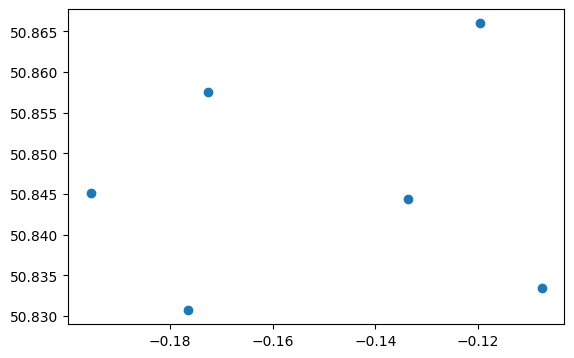

In [71]:
brighton_sites.plot()

NameError: name 'plt' is not defined

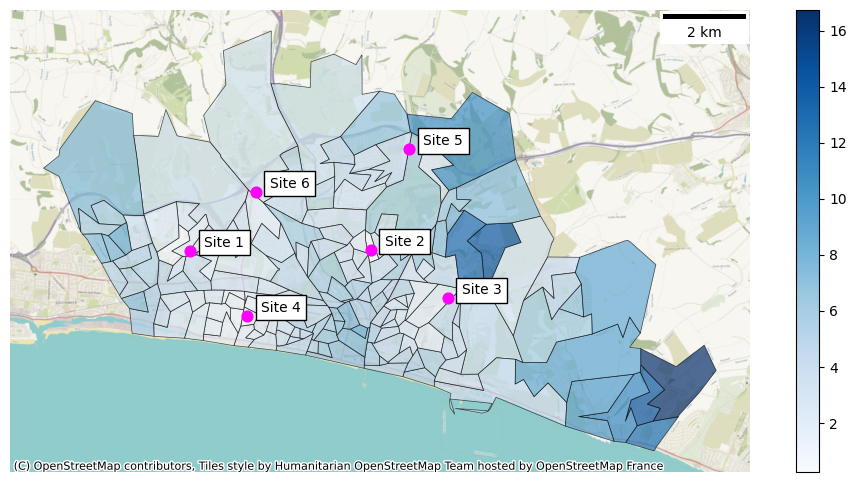

In [72]:
nearest_site_travel_brighton_gdf["shortest_minutes"] = nearest_site_travel_brighton_gdf["shortest"] / 60

ax = nearest_site_travel_brighton_gdf.plot(
    "shortest_minutes",
    legend=True,
    cmap="Blues",
    alpha=0.7,
    edgecolor="black",
    linewidth=0.5,
    figsize=(12,6)
    )

ax.add_artist(ScaleBar(1))

hospital_points = (brighton_sites.to_crs('EPSG:27700')).plot(ax=ax, color='magenta', markersize=60)

cx.add_basemap(ax, crs=nearest_site_travel_brighton_gdf.crs.to_string(), zoom=14)

for x, y, label in zip(brighton_sites.to_crs('EPSG:27700').geometry.x,
                      brighton_sites.to_crs('EPSG:27700').geometry.y,
                      brighton_sites.to_crs('EPSG:27700')[0]):
    ax.annotate(label, xy=(x,y), xytext=(10,3), textcoords="offset points", bbox=dict(facecolor='white'))

ax.axis('off')

plt.title("Travel Time (minutes - driving) to nearest proposed site in Brighton")

In [ ]:
# ax = nearest_site_travel_brighton_gdf.plot(
#     "shortest",
#     legend=True,
#     cmap="Blues",
#     alpha=0.6,
#     edgecolor="black",
#     linewidth=0.5,
#     figsize=(12,6)
#     )

# hospital_points = brighton_sites.plot(ax=ax, color='pink', markersize=40)

# cx.add_basemap(ax, crs=nearest_site_travel_brighton_gdf.crs.to_string(), zoom=14)

# ax.axis('off')

# plt.title("Travel Time (minutes - walking) to proposed sites in Brighton")

Text(0.5, 1.0, 'Travel Time (minutes - cycling) to nearest proposed site in Brighton')

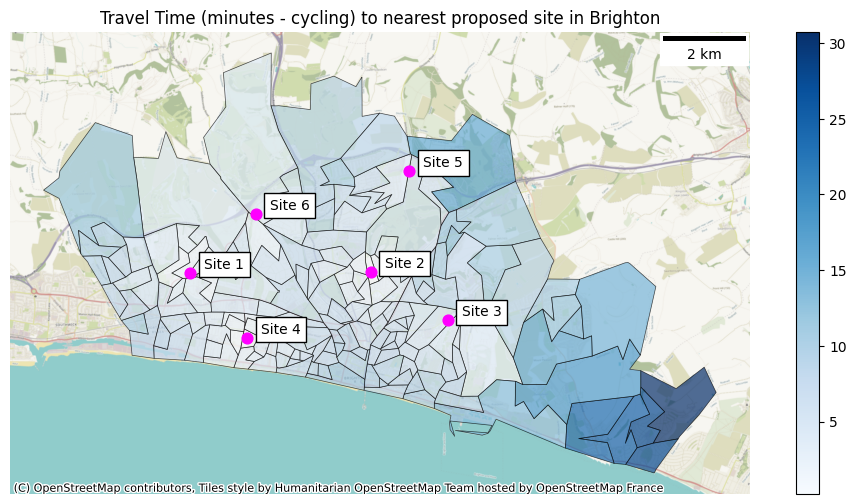

In [ ]:
# Let's calculate a travel matrix assuming our users are walking

sources_indices = [i for i in range(len(source_coord_pairs_list))]

destinations_indices = [i for i in
                        range(
                            # first number in list of indices
                            # this will be 1 more than the number of sources (which were first in our
                            # full list of coordinates)
                            len(source_coord_pairs_list),
                            # last number in list of indices (remember the last number won't
                            # actually be included)
                            len(all_coordinates))
                            ]

location_matrix = ors_api.matrix(

    locations = all_coordinates, # remember this is sources first, then destinations

    profile = 'cycling-regular',

    sources = sources_indices,

    destinations = destinations_indices,

    metrics=["distance", "duration"]

    )

brighton_travel_matrix = pd.DataFrame(
    location_matrix.durations,
    columns=[f"Site {i+1}" for i in range(len(destinations_indices))],
    index=brighton_lsoas_with_coords.LSOA
    )

brighton_travel_matrix['shortest'] = brighton_travel_matrix.min(axis=1)

nearest_site_travel_brighton_gdf = pd.merge(
    lsoa_boundaries,
    brighton_travel_matrix.reset_index(),
    right_on = "LSOA",
    left_on = "LSOA11NM"
)

nearest_site_travel_brighton_gdf["shortest_minutes"] = nearest_site_travel_brighton_gdf["shortest"] / 60

ax = nearest_site_travel_brighton_gdf.plot(
    "shortest_minutes",
    legend=True,
    cmap="Blues",
    alpha=0.7,
    edgecolor="black",
    linewidth=0.5,
    figsize=(12,6)
    )

ax.add_artist(ScaleBar(1))

hospital_points = (brighton_sites.to_crs('EPSG:27700')).plot(ax=ax, color='magenta', markersize=60)

cx.add_basemap(ax, crs=nearest_site_travel_brighton_gdf.crs.to_string(), zoom=14)

for x, y, label in zip(brighton_sites.to_crs('EPSG:27700').geometry.x,
                      brighton_sites.to_crs('EPSG:27700').geometry.y,
                      brighton_sites.to_crs('EPSG:27700')[0]):
    ax.annotate(label, xy=(x,y), xytext=(10,3), textcoords="offset points", bbox=dict(facecolor='white'))

ax.axis('off')

plt.title("Travel Time (minutes - cycling) to nearest proposed site in Brighton")

In [ ]:
locations[0]

[50.84510657697442, -0.19543939173180552]

In [ ]:
isochrone = ors_api.isochrones(
    locations=locations_long_lat[0], # just our first site
    profile="foot-walking",
    intervals=[5*60, 10*60, 15*60] # list of intervals in seconds
    )

In [ ]:
isochrone._isochrones

[Isochrone([[-0.201365, 50.846533], [-0.200663, 50.844383], [-0.200081, 50.843458], [-0.198671, 50.84302], [-0.194643, 50.842261], [-0.194283, 50.842246], [-0.190174, 50.843686], [-0.190083, 50.844034], [-0.190461, 50.845885], [-0.190487, 50.845964], [-0.190677, 50.84627], [-0.192505, 50.847881], [-0.192837, 50.84802], [-0.194892, 50.848886], [-0.197832, 50.847804], [-0.201325, 50.846891], [-0.201365, 50.846533]], 300),
 Isochrone([[-0.205816, 50.843571], [-0.205788, 50.843212], [-0.203126, 50.840522], [-0.202821, 50.840329], [-0.201734, 50.83994], [-0.198662, 50.838961], [-0.194675, 50.838592], [-0.191451, 50.839711], [-0.187835, 50.841221], [-0.184587, 50.842418], [-0.184521, 50.842772], [-0.185003, 50.847422], [-0.185057, 50.847778], [-0.185956, 50.848514], [-0.190201, 50.850438], [-0.191649, 50.851287], [-0.194053, 50.852353], [-0.196914, 50.852308], [-0.197383, 50.852096], [-0.199403, 50.850978], [-0.204767, 50.848819], [-0.205816, 50.843571]], 600),
 Isochrone([[-0.211394, 50.843

In [ ]:
# isochrone.reverse()

[Isochrone([[-0.201365, 50.846533], [-0.200663, 50.844383], [-0.200081, 50.843458], [-0.198671, 50.84302], [-0.194643, 50.842261], [-0.194283, 50.842246], [-0.190174, 50.843686], [-0.190083, 50.844034], [-0.190461, 50.845885], [-0.190487, 50.845964], [-0.190677, 50.84627], [-0.192505, 50.847881], [-0.192837, 50.84802], [-0.194892, 50.848886], [-0.197832, 50.847804], [-0.201325, 50.846891], [-0.201365, 50.846533]], 300),
 Isochrone([[-0.205816, 50.843571], [-0.205788, 50.843212], [-0.203126, 50.840522], [-0.202821, 50.840329], [-0.201734, 50.83994], [-0.198662, 50.838961], [-0.194675, 50.838592], [-0.191451, 50.839711], [-0.187835, 50.841221], [-0.184587, 50.842418], [-0.184521, 50.842772], [-0.185003, 50.847422], [-0.185057, 50.847778], [-0.185956, 50.848514], [-0.190201, 50.850438], [-0.191649, 50.851287], [-0.194053, 50.852353], [-0.196914, 50.852308], [-0.197383, 50.852096], [-0.199403, 50.850978], [-0.204767, 50.848819], [-0.205816, 50.843571]], 600),
 Isochrone([[-0.211394, 50.843

In [ ]:
lon_lat_list = isochrone[0].geometry

lon_lat_list

[[-0.201365, 50.846533],
 [-0.200663, 50.844383],
 [-0.200081, 50.843458],
 [-0.198671, 50.84302],
 [-0.194643, 50.842261],
 [-0.194283, 50.842246],
 [-0.190174, 50.843686],
 [-0.190083, 50.844034],
 [-0.190461, 50.845885],
 [-0.190487, 50.845964],
 [-0.190677, 50.84627],
 [-0.192505, 50.847881],
 [-0.192837, 50.84802],
 [-0.194892, 50.848886],
 [-0.197832, 50.847804],
 [-0.201325, 50.846891],
 [-0.201365, 50.846533]]

In [ ]:
[ x[1],x[0] for x in lon_lat_list ]

SyntaxError: invalid syntax (1106621077.py, line 1)

In [ ]:
polygon_geom = Polygon([ [ x[1],x[0] ] for x in lon_lat_list ])
polygon = geopandas.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom])

polygon

,geometry
0,"POLYGON ((50.84653 -0.20136, 50.84438 -0.20066..."


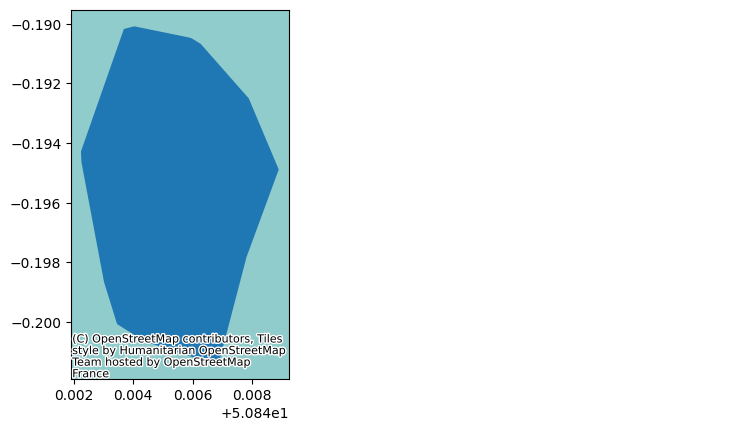

In [ ]:
ax = polygon.plot()
cx.add_basemap(ax=ax, zoom=12)

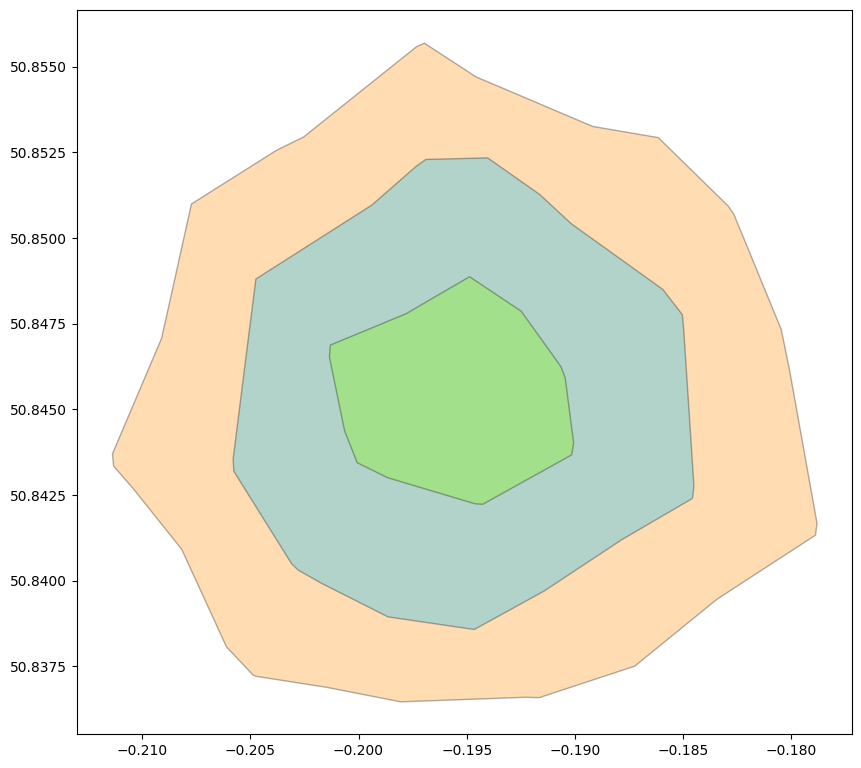

In [ ]:
color_list=["darkorange", "deepskyblue", "chartreuse"]

fig, ax = plt.subplots(figsize=(10,10))

number_of_isochrones = len(isochrone)

for i in range(len(isochrone)):
    lon_lat_list = isochrone[number_of_isochrones-i-1].geometry

    polygon_geom = Polygon(lon_lat_list)
    polygon = geopandas.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom])

    polygon.plot(ax=ax, alpha=0.3, edgecolor='black', color=color_list[i])


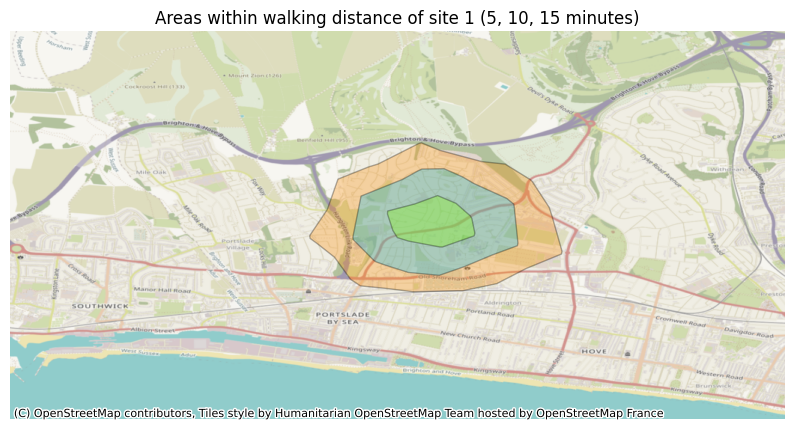

In [ ]:

color_list=["darkorange", "deepskyblue", "chartreuse"]

fig, ax = plt.subplots(figsize=(10,10))

number_of_isochrones = len(isochrone)

for i in range(len(isochrone)):
    lon_lat_list = isochrone[number_of_isochrones-i-1].geometry

    polygon_geom = Polygon(lon_lat_list)
    polygon = geopandas.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom])

    polygon.plot(ax=ax, alpha=0.3, edgecolor='black', color=color_list[i])

brighton_sites.iloc[[0]].plot(ax=ax, color='magenta', markersize=60)

ax.axis('off')

plt.title("Areas within walking distance of site 1 (5, 10, 15 minutes)")

ax.set_xlim([-0.25, -0.15])
ax.set_ylim([50.82, 50.87])

cx.add_basemap(ax, crs=polygon.crs.to_string(), zoom=14)


<AxesSubplot: >

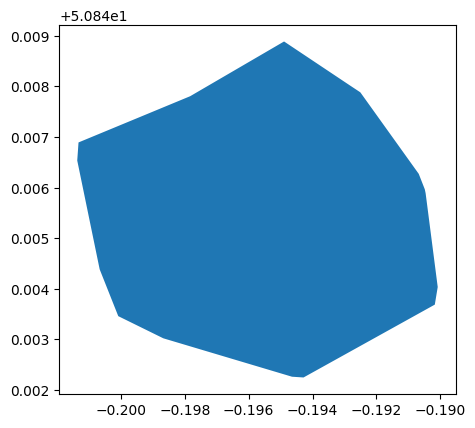

In [ ]:
ax = polygon.plot()

In [74]:
example_matrix = ors_api.matrix(
    locations = [[-0.195439, 50.845107],
                [-0.133654, 50.844345],
                [-0.107633, 50.83347],
                [-0.176522, 50.83075],
                [-0.119614, 50.865971],
                [-0.172591, 50.857582],
                [-0.141603, 50.825428],
                [-0.138366, 50.826784],
                [-0.144071, 50.822038],
                [-0.151026, 50.823046]],

    profile='driving-car',

    sources=[0, 1, 2, 3, 4, 5, 6, 7],

    destinations=[8, 9]
)

example_matrix

Matrix([[782.96, 701.01], [463.7, 571.45], [510.45, 625.08], [421.58, 339.63], [640.16, 747.91], [603.3, 588.52], [87.22, 224.18], [178.09, 315.06]], None)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6c661ea7-9b58-4649-92ed-c2a834b4f69c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>